# K-means Penguins

## Model Objectives:
- Dataset (penguins clean)
- Demonstrate how segmentation can be accomplished using K-means
- Demonstrate how PCA affects reduction / explained variance
- For THIS demonstration - we WILL check with labels
    - This is NOT realistic, in practice will analyse the results of the segmentation

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

## Load the Dataset

This template is originally built using the iris dataset. It recreates how species could be identified if unknown. It is not demonstrating how to identify a new classification / segment.

In [2]:
data = pd.read_csv('./penguins_clean.csv')
df = data.copy()

## Add Features to the DF

In [3]:
df

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181,3750,Male
1,Adelie,Torgersen,39.5,17.4,186,3800,Female
2,Adelie,Torgersen,40.3,18.0,195,3250,Female
3,Adelie,Torgersen,36.7,19.3,193,3450,Female
4,Adelie,Torgersen,39.3,20.6,190,3650,Male
...,...,...,...,...,...,...,...
328,Gentoo,Biscoe,47.2,13.7,214,4925,Female
329,Gentoo,Biscoe,46.8,14.3,215,4850,Female
330,Gentoo,Biscoe,50.4,15.7,222,5750,Male
331,Gentoo,Biscoe,45.2,14.8,212,5200,Female


In [4]:
# not required
df['species'].unique()

array(['Adelie', 'Chinstrap', 'Gentoo'], dtype=object)

## EDA

In [5]:
df.isna().sum()

species              0
island               0
bill_length_mm       0
bill_depth_mm        0
flipper_length_mm    0
body_mass_g          0
sex                  0
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 333 entries, 0 to 332
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            333 non-null    object 
 1   island             333 non-null    object 
 2   bill_length_mm     333 non-null    float64
 3   bill_depth_mm      333 non-null    float64
 4   flipper_length_mm  333 non-null    int64  
 5   body_mass_g        333 non-null    int64  
 6   sex                333 non-null    object 
dtypes: float64(2), int64(2), object(3)
memory usage: 18.3+ KB


In [7]:
# Convert any data types as required
columns_to_convert = ['species', 'island', 'sex']
for col in columns_to_convert:
    df[col] = df[col].astype('category')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 333 entries, 0 to 332
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   species            333 non-null    category
 1   island             333 non-null    category
 2   bill_length_mm     333 non-null    float64 
 3   bill_depth_mm      333 non-null    float64 
 4   flipper_length_mm  333 non-null    int64   
 5   body_mass_g        333 non-null    int64   
 6   sex                333 non-null    category
dtypes: category(3), float64(2), int64(2)
memory usage: 11.9 KB


## Prep the Data (X and label) 
### label for training, real life scenario does not include a y or y-hat

In [8]:
# using only two independent variables / features for this pass
X = df.drop(['species', 'island'], axis = 1)
label = df['species']

In [9]:
X

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,39.1,18.7,181,3750,Male
1,39.5,17.4,186,3800,Female
2,40.3,18.0,195,3250,Female
3,36.7,19.3,193,3450,Female
4,39.3,20.6,190,3650,Male
...,...,...,...,...,...
328,47.2,13.7,214,4925,Female
329,46.8,14.3,215,4850,Female
330,50.4,15.7,222,5750,Male
331,45.2,14.8,212,5200,Female


In [10]:
# one hot encoding needed
# one-hot encoding
X = pd.get_dummies(X, drop_first=True)
X.head()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex_Male
0,39.1,18.7,181,3750,True
1,39.5,17.4,186,3800,False
2,40.3,18.0,195,3250,False
3,36.7,19.3,193,3450,False
4,39.3,20.6,190,3650,True


## Standardize the Data
KMeans is effected by scale so you need to scale the features in the data before using KMeans. 
- You can transform the data onto unit scale (mean = 0 and variance = 1) for better performance. Scikit-Learn's `StandardScaler` helps standardize the dataset’s features.

In [11]:
# seperated out the fit and transform for clarity
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

X[0:5]

array([[-0.89604189,  0.7807321 , -1.42675157, -0.56847478,  0.99103121],
       [-0.82278787,  0.11958397, -1.06947358, -0.50628618, -1.00904996],
       [-0.67627982,  0.42472926, -0.42637319, -1.1903608 , -1.00904996],
       [-1.33556603,  1.0858774 , -0.56928439, -0.94160639, -1.00904996],
       [-0.85941488,  1.74702554, -0.78365118, -0.69285199,  0.99103121]])

## Plot Data to Estimate Number of Clusters
If your data is 2 or three dimensional, it is a good idea to plot your data before clustering. Hopefully you can see if there are any natural looking clusters. 

In [12]:
# More then 3 - use PCA
# Scatter Plot - adding the hue of the known species for clarity
# sns.scatterplot(df, x='petal_length', y='petal_width', hue='species');

## PCA Projection

In [13]:
# instantiate instance of PCA
pca = PCA(n_components=2)

In [14]:
princ_comps = pca.fit_transform(X)

In [15]:
princ_comps_df = pd.DataFrame(data = princ_comps, columns = ['princ_comp1', 'princ_comp2'])
princ_comps_df.head()

,princ_comp1,princ_comp2
0,-1.568834,1.190270
1,-1.531779,-0.721542
2,-1.581776,-0.591227
3,-2.048580,-0.245575
4,-1.578723,1.760409


## Visualize 2D Projection
PCA projection to 2D to visualize the entire data set. 

In [16]:
princ_comps_df['label'] = label
princ_comps_df.head()

,princ_comp1,princ_comp2,label
0,-1.568834,1.190270,Adelie
1,-1.531779,-0.721542,Adelie
2,-1.581776,-0.591227,Adelie
3,-2.048580,-0.245575,Adelie
4,-1.578723,1.760409,Adelie


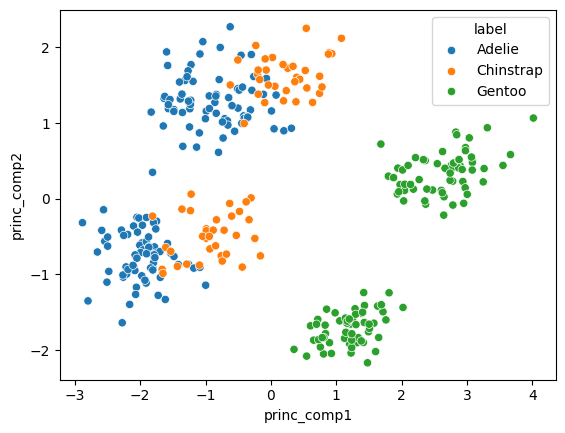

In [17]:
sns.scatterplot(data = princ_comps_df, x= 'princ_comp1', y = 'princ_comp2', hue='label');

## Explained Variance

In [18]:
pca.explained_variance_ratio_, sum(pca.explained_variance_ratio_)

(array([0.56712378, 0.28143634]), np.float64(0.8485601150474257))

In [19]:
print(f'These principal component contains ~ {(sum(pca.explained_variance_ratio_)) *100:.3}% of the information in the dataset.')

These principal component contains ~ 84.9% of the information in the dataset.


## KMeans Clustering
In K-Means clustering, you need to specify the number of clusters (k) you want. In Scikit-Learn, this parameter is called `n_clusters`.   

In [20]:
# Make an instance of KMeans with 3 clusters
kmeans = KMeans(n_clusters=6, random_state=42)

# Fit only on a features matrix
kmeans.fit(X)

KMeans(n_clusters=6, random_state=42)

In [21]:
# Get labels and cluster centroids
k_labels = kmeans.labels_
centroids = kmeans.cluster_centers_

In [22]:
k_labels, centroids

(array([5, 2, 2, 2, 5, 2, 5, 2, 5, 5, 2, 2, 5, 2, 3, 2, 5, 2, 5, 5, 2, 5,
        2, 2, 5, 2, 5, 2, 5, 2, 5, 5, 2, 2, 5, 2, 5, 2, 5, 2, 5, 5, 2, 5,
        2, 5, 2, 5, 2, 5, 2, 5, 2, 5, 2, 5, 2, 5, 2, 5, 2, 5, 2, 5, 2, 5,
        2, 3, 2, 5, 2, 5, 2, 5, 2, 5, 2, 5, 2, 5, 5, 2, 5, 2, 2, 5, 2, 5,
        2, 5, 2, 5, 2, 5, 2, 5, 2, 5, 2, 5, 2, 5, 2, 5, 2, 5, 2, 5, 2, 5,
        2, 5, 2, 5, 2, 5, 2, 5, 2, 5, 2, 5, 2, 5, 2, 5, 2, 5, 2, 5, 2, 5,
        2, 5, 2, 5, 2, 5, 2, 5, 5, 2, 2, 5, 2, 5, 0, 3, 3, 0, 3, 0, 0, 3,
        0, 3, 0, 3, 0, 3, 0, 3, 3, 0, 0, 3, 2, 3, 0, 3, 0, 3, 0, 3, 0, 3,
        2, 3, 0, 3, 3, 0, 0, 3, 0, 3, 3, 0, 3, 0, 0, 3, 0, 3, 3, 0, 0, 3,
        0, 3, 0, 3, 0, 3, 3, 0, 3, 0, 0, 3, 0, 3, 3, 0, 1, 4, 1, 4, 4, 1,
        1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 4, 1, 1, 4, 1, 4, 4, 1,
        4, 4, 1, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 4, 1, 1, 4, 1, 4, 1,
        4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 4, 1, 4, 1, 4, 4, 1,
        1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 

In [23]:
df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181,3750,Male
1,Adelie,Torgersen,39.5,17.4,186,3800,Female
2,Adelie,Torgersen,40.3,18.0,195,3250,Female
3,Adelie,Torgersen,36.7,19.3,193,3450,Female
4,Adelie,Torgersen,39.3,20.6,190,3650,Male


In [24]:
df['k_labels'] = k_labels
df.to_csv('./kmeans_penguins_res_6.csv')
df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,k_labels
0,Adelie,Torgersen,39.1,18.7,181,3750,Male,5
1,Adelie,Torgersen,39.5,17.4,186,3800,Female,2
2,Adelie,Torgersen,40.3,18.0,195,3250,Female,2
3,Adelie,Torgersen,36.7,19.3,193,3450,Female,2
4,Adelie,Torgersen,39.3,20.6,190,3650,Male,5


In [28]:
# do some EDA on the outputs...
df[['species', 'sex', 'k_labels']].value_counts()


species    sex     k_labels
Adelie     Female  2           73
           Male    5           71
Gentoo     Male    4           61
           Female  1           58
Chinstrap  Male    3           34
           Female  0           32
Adelie     Male    3            2
Chinstrap  Female  2            2
Name: count, dtype: int64

## Visually Evaluate the Clusters per Proximity to the Centroids

In [26]:
centroids

array([[ 0.52897778,  0.23560275, -0.62510908, -0.83569143, -1.00904996],
       [ 0.28770523, -1.48856681,  0.83888369,  0.58791154, -1.00904996],
       [-1.21201091,  0.22333337, -0.94847543, -1.04152274, -1.00904996],
       [ 1.2476557 ,  1.08870282, -0.09291374, -0.31712919,  0.99103121],
       [ 1.00375917, -0.73582333,  1.47012866,  1.58926579,  0.99103121],
       [-0.68814491,  0.95407755, -0.6175924 , -0.20804366,  0.99103121]])

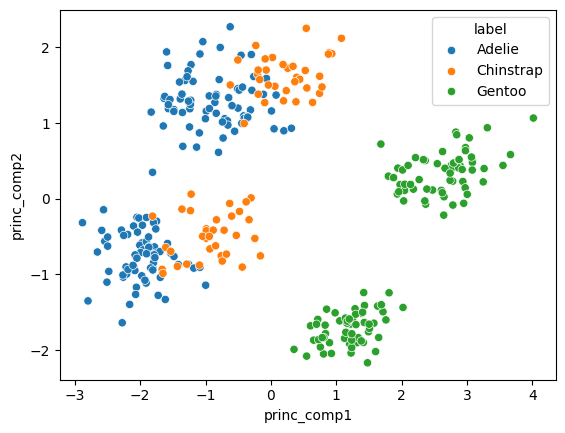

In [27]:
# once beyond 3 dimensions you can visually look to see your segments
sns.scatterplot(data = princ_comps_df, x= 'princ_comp1', y = 'princ_comp2', hue='label');

## Findings / Summary
- 6 appears to be the optimal number of clusters
- The segmentation was improved drastically when islands were removed
- Other findings here